In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d thomasdubail/brain-tumors-256x256

 81% 48.0M/59.4M [00:00<00:00, 134MB/s]
100% 59.4M/59.4M [00:00<00:00, 117MB/s]


In [6]:
!unzip brain-tumors-256x256.zip

Archive:  brain-tumors-256x256.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jpg  
  inflating: Data/glioma_tumor/G_116.jpg  
  inflating: Data/glioma_tumor/G_117.jpg  
  inflating: Data/glioma_tumor/G_118.jpg  
  inflating: Data/gliom

In [7]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [8]:
train_data_dir ='/content/Data'
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 3096 files belonging to 4 classes.
Using 2477 files for training.
Found 3096 files belonging to 4 classes.
Using 619 files for validation.


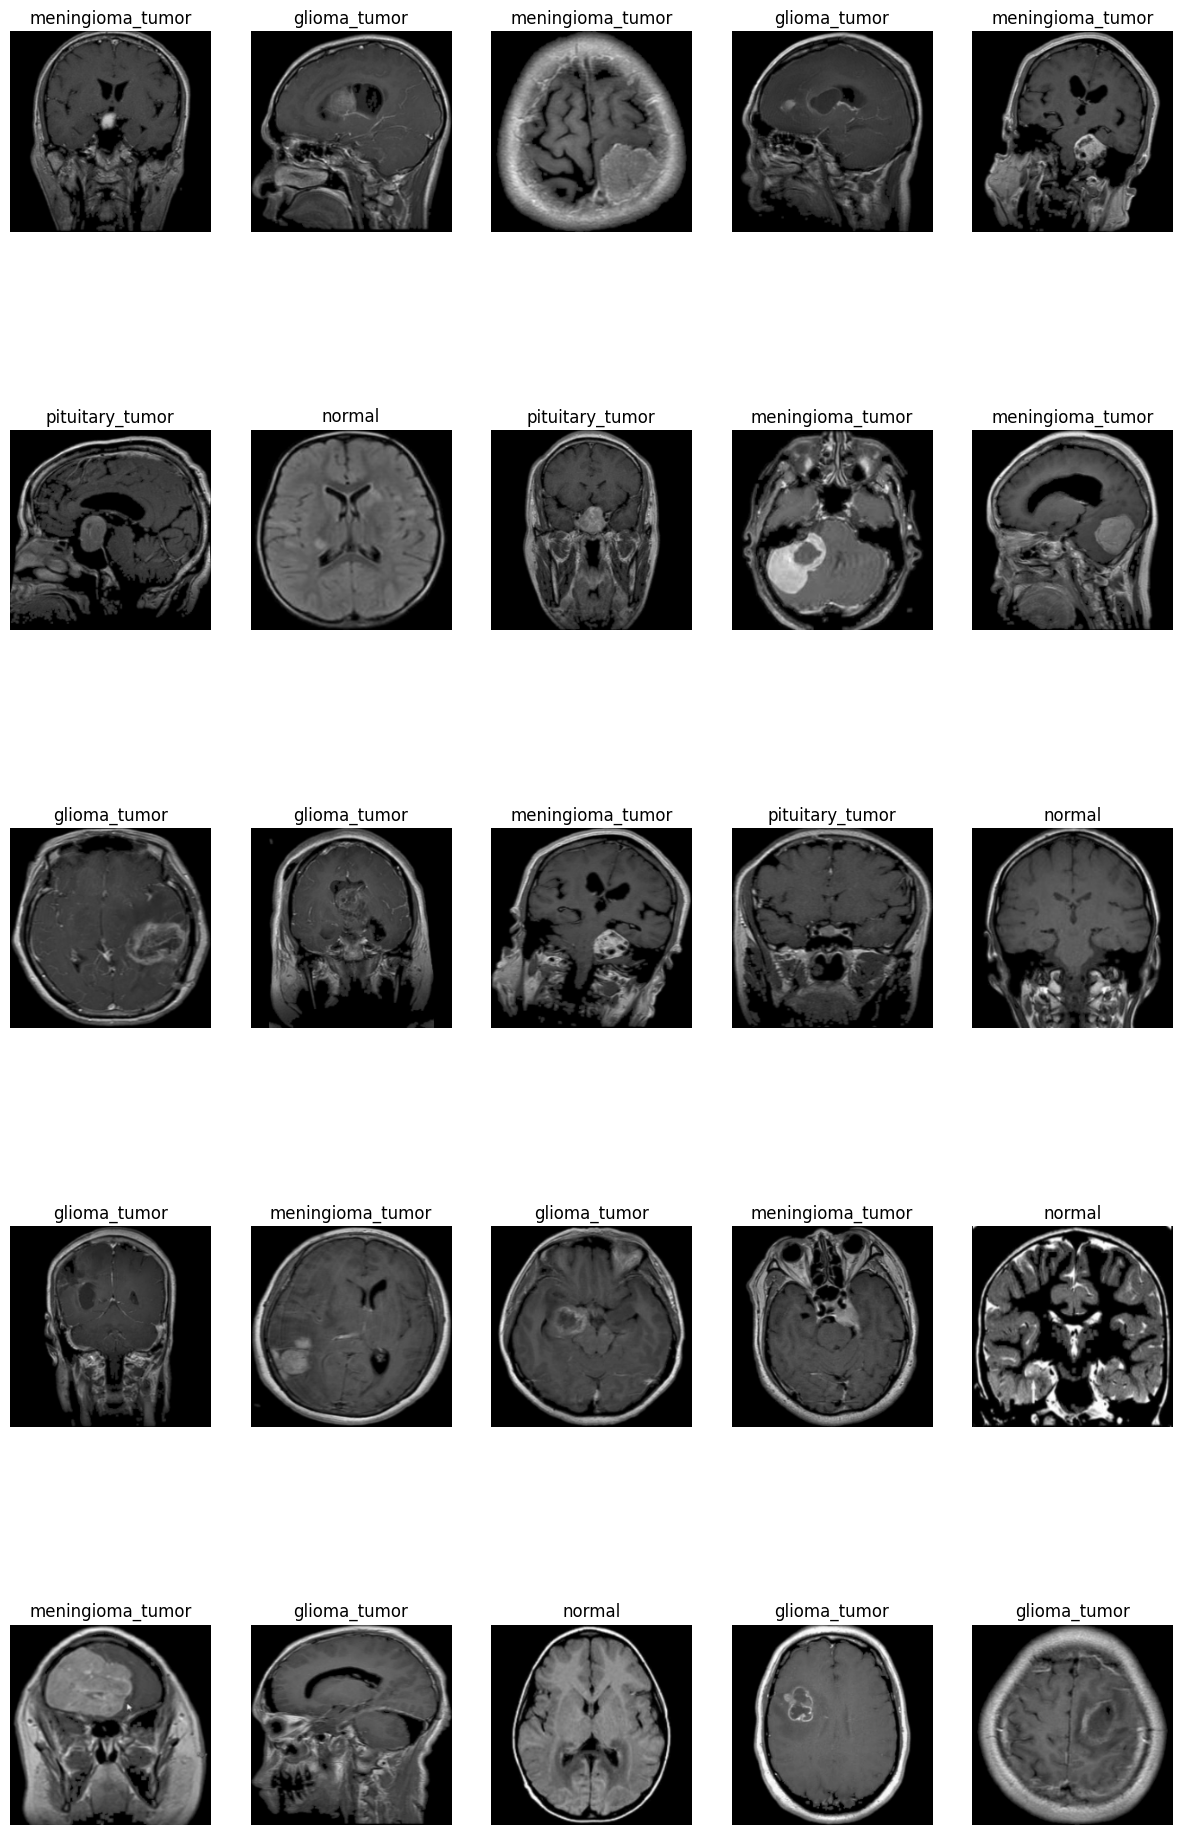

In [55]:
class_names = train.class_names
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

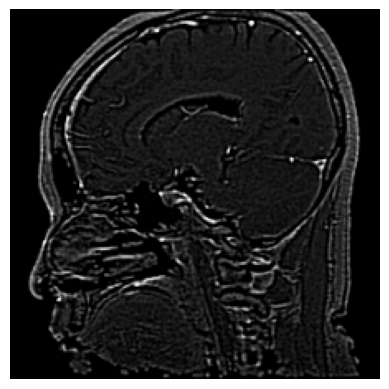

In [29]:
image_path = '/content/Data/pituitary_tumor/P_105.jpg'

image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.array([
    [-1, -1, -1, -1, -1],
    [-1, 1, 1, 1, -1],
    [-1, 1, 9.5, 1, -1],
    [-1, 1, 1, 1, -1],
    [-1, -1, -1, -1, -1]
]) / 4.0
filtered = cv2.filter2D(gray, -1, kernel)

resized_image = cv2.resize(filtered, (224, 224))

final_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

plt.imshow(final_image.astype("uint8"))
plt.axis("off")

In [39]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape = (224,224,3),kernel_size=(3,3),
                                activation='relu',filters = 32,strides=1))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(kernel_size=(3,3),activation='relu',filters = 64,
                             strides=1))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(kernel_size=(3,3),activation='relu',filters = 128,
                             strides=1))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256,activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(128,activation='relu',
                            kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(64,activation='relu',
                            kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(4,activation='softmax'))

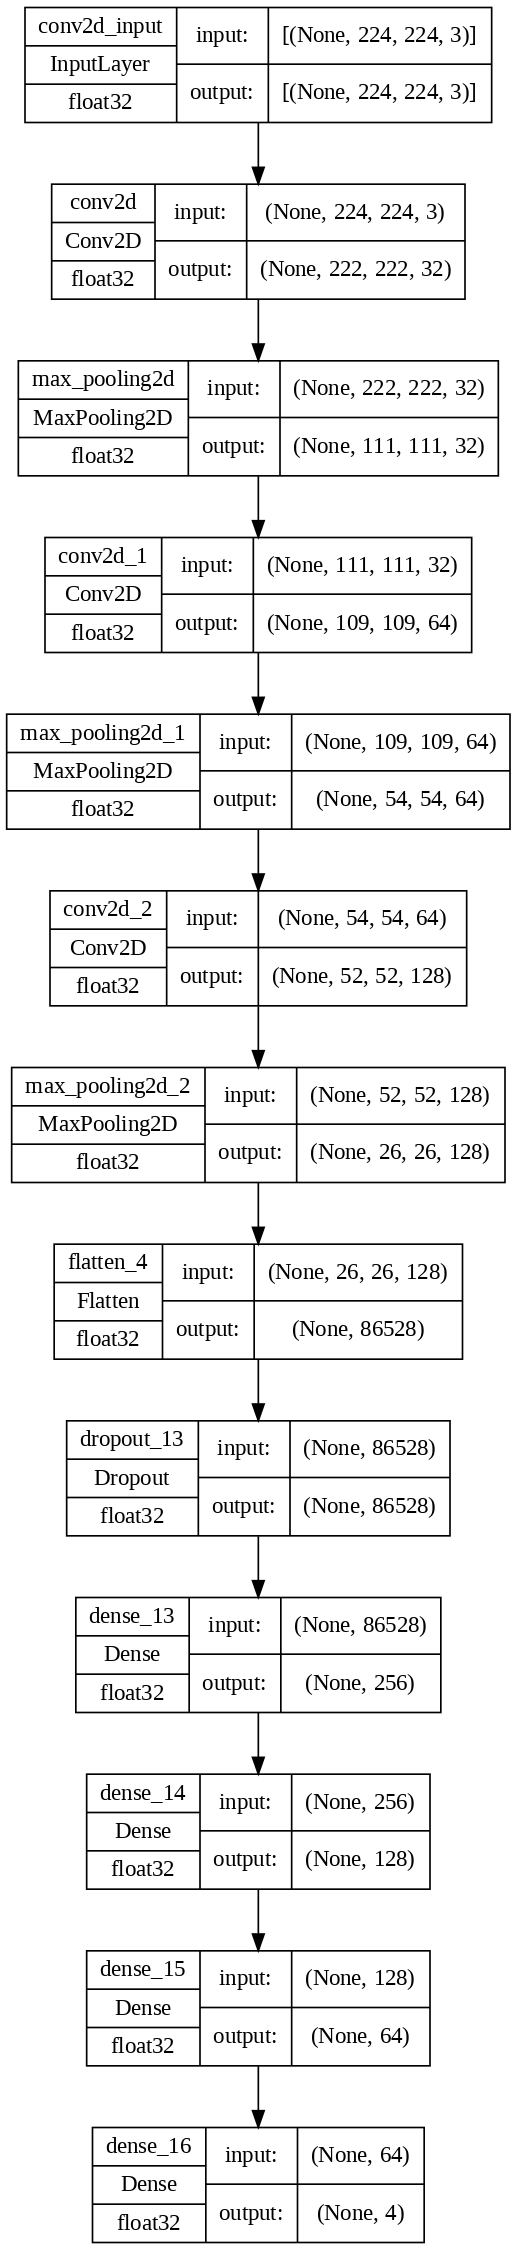

In [40]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [41]:
checkpoint_cb =ModelCheckpoint("mymodel.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
78/78 [==============================] - 13s 99ms/step - loss: 23.2502 - accuracy: 0.4921 - val_loss: 8.6878 - val_accuracy: 0.6801
Epoch 2/20
78/78 [==============================] - 6s 80ms/step - loss: 7.8989 - accuracy: 0.6399 - val_loss: 6.9767 - val_accuracy: 0.6963
Epoch 3/20
78/78 [==============================] - 8s 94ms/step - loss: 6.3740 - accuracy: 0.7247 - val_loss: 5.8429 - val_accuracy: 0.7383
Epoch 4/20
78/78 [==============================] - 6s 80ms/step - loss: 5.4793 - accuracy: 0.7679 - val_loss: 5.0910 - val_accuracy: 0.8174
Epoch 5/20
78/78 [==============================] - 7s 92ms/step - loss: 4.8189 - accuracy: 0.8082 - val_loss: 4.4364 - val_accuracy: 0.8465
Epoch 6/20
78/78 [==============================] - 7s 85ms/step - loss: 4.2269 - accuracy: 0.8373 - val_loss: 3.9257 - val_accuracy: 0.8756
Epoch 7/20
78/78 [==============================] - 8s 101ms/step - loss: 3.8327 - accuracy: 0.8579 - val_loss: 3.5359 - val_accuracy: 0.9321
Epoch 8/20

In [43]:
model.evaluate(validation)

20/20 [==============================] - 1s 40ms/step - loss: 1.9224 - accuracy: 0.9418


[1.9224292039871216, 0.9418416619300842]

20/20 [==============================] - 0s 20ms/step


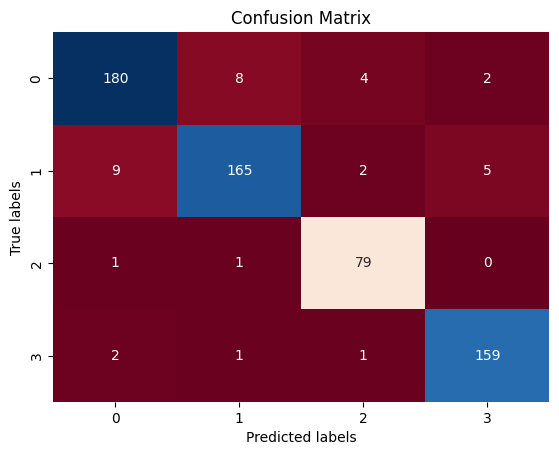

In [48]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [53]:
image_path = '/content/Data/pituitary_tumor/P_114.jpg'

img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
model_path = '/content/mymodel.h5'
model = keras.models.load_model(model_path)
predictions = model.predict(img)
class_labels = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
predicted_class_index = np.argmax(predictions)
predicted_label = class_labels[predicted_class_index]
print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 92ms/step
Predicted Label: pituitary_tumor
